## Results metrics

A threshold "T" is used to classify a test case to be either a correct (true or positive) case or false (negative) case. If the case is below a threshold "T" then it is classified false (negative) and if it is above threshold "T" it is classified true (positive).

**FPIR**: is the false positive identification rate. It is the ratio of the test cases that are classified as true cases although they are false cases. It is type I error. 
FPIR= Number of test cases classified above threshold "T" (true) / Number of all test cases

**FNIR**: is the false negative identification rate. It is  the ratio of the test cases that are classified as false cases although they are true cases. It is type II error.
FNIR= Number of test cases classified below threshold "T" (false) / Number of all test cases

In [177]:
# Load libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt
import torch
import seaborn as sns
import pandas as pd
sns.set(style="white") 
%matplotlib inline

## MagFace Results

**False Negatives**
FNIR represent the proportion of feature vectors that belong to a certain class but are incorrectly classified as not belonging to that class.

##### Load data - children

In [216]:
# Children feature vectors
with open('../data/feat_children.list', 'r') as f:
    lines = f.readlines()


In [217]:
img_2_feats = {}
img_2_mag = {}
# Convert to dictionary as adaface - is done in img_2_feats
for line in lines:
    parts = line.strip().split(' ')
    imgname = parts[0]
    imgname = "/"+"/".join(imgname.split("/")[4:])
    feats = [float(e) for e in parts[1:]]
    mag = np.linalg.norm(feats)
    img_2_feats[imgname] = feats/mag
    img_2_mag[imgname] = mag #magnitude of the feature vector

In [218]:
imgnames = list(img_2_mag.keys())
mags = [img_2_mag[imgname] for imgname in imgnames]
sort_idx = np.argsort(mags) #sorts the magnitude/quality of the images

In [219]:
len(lines)

3306

In [220]:
# For all Ids, get last id name and convert to unique ids
def convert_unique_ids(ids):
    unique_ids_list = []
    for id in ids:
        im_id = id.split("/")[-1][:-4]
        if '.' in im_id:
            un_id = im_id.split("_")[0]
        else:
            un_id = '_'.join(im_id.split("_")[:-1])
            
        unique_ids_list.append(un_id)
    return unique_ids_list
        

In [221]:
#feats = np.array([img_2_feats[imgnames[ele]] for ele in sort_idx[:10]])
#feats = np.array([img_2_feats[imgnames[ele]] for ele in range(10)]) #unsorted image quality
#ids = np.array([imgnames[ele] for ele in range(10)])

feats = np.array([img_2_feats[imgnames[ele]] for ele in range(len(lines))]) #unsorted image quality
ids = np.array([imgnames[ele] for ele in range(len(lines))])

sim_mat = np.dot(feats, feats.T)

In [222]:
def factorize_ids(ids):
    unique_ids = {}
    factors = []
    for id in ids:
        if id not in unique_ids:
            unique_ids[id] = len(unique_ids)  # Assign a unique index for each unique ID
        factors.append(unique_ids[id])  # Append the index corresponding to the ID
    return factors, unique_ids

# Example usage:
ids = convert_unique_ids(ids)
factors_c, unique_ids = factorize_ids(ids)
print("Factorized list:", factors_c[:10])
print("Unique IDs mapping:", unique_ids)

Factorized list: [0, 0, 0, 1, 2, 2, 3, 4, 4, 5]
Unique IDs mapping: {'Indian_682': 0, 'Asian_119': 1, 'Asian_504': 2, 'Caucasian_73': 3, 'Caucasian_249': 4, 'm.01w1069': 5, 'Caucasian_363': 6, 'm.05n': 7, 'Asian_185': 8, 'African_713': 9, 'Indian_702': 10, 'African_627': 11, 'm.06ljz3': 12, 'African_433': 13, 'm.03vq05': 14, 'African_265': 15, 'Asian_59': 16, 'African_415': 17, 'African_274': 18, 'Indian_458': 19, 'Caucasian_244': 20, 'm.0j259dq': 21, 'African_571': 22, 'African_246': 23, 'African_743': 24, 'African_486': 25, 'Asian_137': 26, 'm.04gh78q': 27, 'Indian_711': 28, 'Asian_672': 29, 'Indian_115': 30, 'Asian_638': 31, 'Indian_267': 32, 'African_665': 33, 'Indian_474': 34, 'African_767': 35, 'Indian_346': 36, 'Caucasian_1323': 37, 'Indian_442': 38, 'Indian_676': 39, 'Asian_420': 40, 'African_305': 41, 'Indian_616': 42, 'm.04y7f4r': 43, 'm.0d5060': 44, 'Indian_484': 45, 'm.05sxmf7': 46, 'm.0gcslnm': 47, 'm.05t2cs': 48, 'Asian_663': 49, 'Indian_635': 50, 'Caucasian_167': 51, 'In

In [223]:
# Analyze similarity scores in terms of threshold...
# For the first 10 similarity scores - what is the distribution of the scores?
sim_scores = sim_mat


In [226]:
## Data check

sim_scores = sim_mat.copy()
# E.g. classify all identities as positive if threshold is higher than 90% of all similarity scores
sims_excluding_probe = sim_scores[sim_scores < 0.9999] # OBs check if more scientific way
# Check that length of similarity scores are equal to len(sim_scores.flatten)- len(sim_scores)
print("Length of similarity scores without probe: ", len(sims_excluding_probe), "Equal to: ", len(sim_scores.flatten()) - len(sim_scores), 
      "is",len(sims_excluding_probe) == (len(sim_scores.flatten()) - len(sim_scores)))


Length of similarity scores without probe:  10926330 Equal to:  10926330 is True


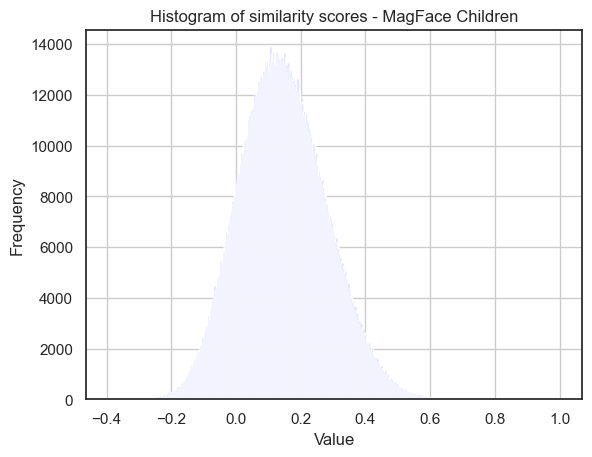

Average similarity score:  0.14614945447812053

Top 10% similarity score:  0.42232515616646227

Top 10 highest similarity score: [0.98039976 0.98039976 0.98334116 0.98334116 0.98468605 0.98468605
 0.98944222 0.98944222 0.99989667 0.99989667]

Max sim scores:  0.9998966723251195


In [227]:
# Convert tensor to NumPy array
plot_sims = sim_scores[sim_scores < 0.9999].reshape(-1) # filter out values equal to 1 #OBS check more scietific way
# Plot histogram
plt.hist(plot_sims, bins=len(sim_scores), color='blue', alpha=0.7)
plt.title('Histogram of similarity scores - MagFace Children')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print("Average similarity score: ", np.mean(plot_sims))
print("\nTop 10% similarity score: ", np.percentile(plot_sims, 97.5))
print("\nTop 10 highest similarity score:", np.sort(plot_sims)[-10:])
print("\nMax sim scores: ", np.max(plot_sims))

In [228]:
## Function for calculating confusion matrix scores


# False Positives = Number of instances belonging to the negative class but are classified as the positive class
# True Negatives = Number of instances belonging to the negative class that are correctly classsified as the negative class
# True positives: N instances belonging to the positive class that were also correctly classified as the positive class
# False negatives: N instances belonging to the positive class that were incorrectly classified to the negative class


def remove_probeid_in_classification(arr, value):
    for i, v in enumerate(arr):
        if v == value:
            return np.delete(arr, i)
    return arr  # Value not found in the array, return the original array

def confusion_matrix_scores(thold, sim_scores, im_ids):
    tps = []
    fps = []
    tns = []
    fns = []

    for i in range(0,len(sim_scores)):
        probe = im_ids[i]
        print(probe)
        
        # for probe i
        # Positive classification list
        classified_positive_list = sim_scores[i] >= thold
        classified_positive_idx = list(np.where(classified_positive_list)[0])
            
        # get the classified identities - positive
        face_idx_pos_class = im_ids[classified_positive_idx]
        print("correct ids",face_idx_pos_class)
        
        # remove first instance of probe id in classification list
        face_idx_pos_class_filtered = remove_probeid_in_classification(face_idx_pos_class, probe)
        print("filtered ids",face_idx_pos_class_filtered)

        ### Only for closed set
        # get TP
        tp = np.sum(face_idx_pos_class_filtered == probe)
        tps.append(tp)
        
        # get FP (classified as correct but not equal to probe)
        fp = len(face_idx_pos_class_filtered) - tp
        fps.append(fp)
        
        # Negative classification list
        classified_negative_list = sim_scores[i] < thold
        classified_negative_idx = list(np.where(classified_negative_list)[0])
        
        # get the classified identities - negative
        face_idx_neg_class = im_ids[classified_negative_idx]
        face_idx_neg_class_filtered = remove_probeid_in_classification(face_idx_neg_class, probe)


        # get TN (classified as false and not equal to probe)
        tn = np.sum(face_idx_neg_class_filtered != probe)
        tns.append(tn)
        
        # get FN (classified as false, but is actually equal to probe)
        fn = len(face_idx_neg_class_filtered) - tn
        fns.append(fn)
        
    return tps, fps, tns, fns


In [229]:
# children

## Threshold set based on studying the similarity scores
thold_c = np.percentile(plot_sims, 99)
im_ids = np.array(factors_c)

tps_c, fps_c, tns_c, fns_c = confusion_matrix_scores(thold_c, sim_scores, im_ids)

n_comparisons_children = len(plot_sims)
print("Number of comparisons for adults: ", n_comparisons_children)
print("Number of probes adults", len(im_ids))

0
correct ids [   0    0    0  231 1111 1415 1603]
filtered ids [   0    0  231 1111 1415 1603]
0
correct ids [   0    0    0  173  216  312  377  411  619  687  697  941 1082 1111
 1579 1868]
filtered ids [   0    0  173  216  312  377  411  619  687  697  941 1082 1111 1579
 1868]
0
correct ids [   0    0    0  143  173  312  377  687  687  914 1507 1529]
filtered ids [   0    0  143  173  312  377  687  687  914 1507 1529]
1
correct ids [   1   16   31   40   57   57  141  171  171  171  215  247  263  268
  279  281  281  304  304  308  315  318  333  347  352  357  358  358
  364  367  375  452  464  464  504  561  572  572  585  632  632  632
  647  661  678  700  724  742  745  745  746  747  761  775  834  855
  893  893  895  896  940  940  940  952  952  960  960  960  975 1028
 1035 1035 1039 1049 1071 1081 1116 1132 1140 1145 1146 1159 1169 1169
 1189 1189 1194 1212 1217 1235 1239 1242 1242 1244 1247 1247 1270 1270
 1280 1280 1295 1295 1295 1295 1304 1306 1359 1359 1398 142

##### Load data - adults


In [230]:
# Children feature vectors
with open('../data/feat_adults.list', 'r') as f:
    lines = f.readlines()


In [231]:
img_2_feats = {}
img_2_mag = {}
# Convert to dictionary as adaface - is done in img_2_feats
for line in lines:
    parts = line.strip().split(' ')
    imgname = parts[0]
    imgname = "/"+"/".join(imgname.split("/")[4:])
    feats = [float(e) for e in parts[1:]]
    mag = np.linalg.norm(feats)
    img_2_feats[imgname] = feats/mag
    img_2_mag[imgname] = mag #magnitude of the feature vector

In [232]:
imgnames = list(img_2_mag.keys())
mags = [img_2_mag[imgname] for imgname in imgnames]
sort_idx = np.argsort(mags) #sorts the magnitude/quality of the images

In [233]:
len(lines)

3306

In [234]:
#feats = np.array([img_2_feats[imgnames[ele]] for ele in sort_idx[:10]])
#feats = np.array([img_2_feats[imgnames[ele]] for ele in range(10)]) #unsorted image quality
#ids = np.array([imgnames[ele] for ele in range(10)])

feats = np.array([img_2_feats[imgnames[ele]] for ele in range(len(lines))]) #unsorted image quality
ids = np.array([imgnames[ele] for ele in range(len(lines))])

sim_mat = np.dot(feats, feats.T)

In [235]:
# convert ids
ids = convert_unique_ids(ids)
factors_a, unique_ids = factorize_ids(ids)
print("Factorized list:", factors_a[:10])
print("Unique IDs mapping:", unique_ids)

Factorized list: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Unique IDs mapping: {'m.0dgs2bj': 0, 'm.0gvvhrh': 1, 'm.02x68cc': 2, 'm.0b1hcy': 3, 'm.0415s': 4, 'm.04jhsnv': 5, 'm.0b1q1n': 6, 'm.04mq82': 7, 'm.064pss2': 8, 'm.05101': 9, 'm.0d5qwl': 10, 'm.04hx87': 11, 'm.08l4b1': 12, 'm.03mdl8': 13, 'm.0h06p': 14, 'm.04n1s8l': 15, 'm.02vgny': 16, 'm.0927fr': 17, 'm.02r7lyb': 18, 'm.02r80b9': 19, 'm.01c': 20, 'm.0brpvb': 21, 'm.0640hcc': 22, 'm.02qh579': 23, 'm.03yht5f': 24, 'm.0k0r6km': 25, 'm.02fxn0': 26, 'm.04bcx9': 27, 'm.08y5xt': 28, 'm.0q3': 29, 'm.0dxmls': 30, 'm.0cz9bfj': 31, 'm.0473wx': 32, 'm.0c2cz6': 33, 'm.02qkhs1': 34, 'm.0f1cgl': 35, 'm.0dt1cm': 36, 'm.0gkyfzc': 37, 'm.03hhp4z': 38, 'm.04mvcl': 39, 'm.08vff9': 40, 'm.039xxb': 41, 'm.0tj9': 42, 'm.0jwn': 43, 'm.08lp99': 44, 'm.0h1pk8': 45, 'm.01pwdt': 46, 'm.02r77ks': 47, 'm.0gfd1h7': 48, 'm.04c1g2': 49, 'm.0h97qhx': 50, 'm.01mvhpl': 51, 'm.026r159': 52, 'm.01w78ry': 53, 'm.05bnbs': 54, 'm.04gsv7v': 55, 'm.09': 56, 'm.027wj9j': 57, 'm.044

In [236]:
## Data check
sim_scores_a = sim_mat.copy()
# E.g. classify all identities as positive if threshold is higher than 90% of all similarity scores
sims_excluding_probe = sim_scores_a[sim_scores_a < 0.99] # OBs check if more scientific way
# Check that length of similarity scores are equal to len(sim_scores.flatten)- len(sim_scores)
print("Length of similarity scores without probe: ", len(sims_excluding_probe), "Equal to: ", len(sim_scores_a.flatten()) - len(sim_scores_a), 
      "is",len(sims_excluding_probe) == (len(sim_scores_a.flatten()) - len(sim_scores_a)))


Length of similarity scores without probe:  10926330 Equal to:  10926330 is True


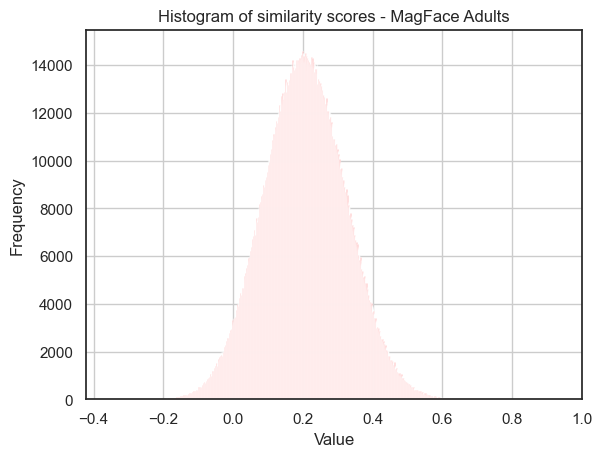

Average similarity score:  0.20604788258925932

Top 10% similarity score:  0.4404752278903723

Top 10 highest similarity score: [0.80635714 0.80635714 0.80751627 0.80751627 0.83381147 0.83381147
 0.88859401 0.88859401 0.93653139 0.93653139]

Max sim scores:  0.9365313871699896


In [237]:
# Analyze similarity scores in terms of threshold...
# For the first 10 similarity scores - what is the distribution of the scores?
plot_sims_a = sim_scores_a[sim_scores_a < 0.999].reshape(-1) # filter out values equal to 1 #OBS check more scietific way
# Plot histogram
plt.hist(plot_sims_a, bins=len(sim_scores_a), color='red', alpha=0.5)
plt.title('Histogram of similarity scores - MagFace Adults')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print("Average similarity score: ", np.mean(plot_sims_a))
print("\nTop 10% similarity score: ", np.percentile(plot_sims_a, 97.5))
print("\nTop 10 highest similarity score:", np.sort(plot_sims_a)[-10:])
print("\nMax sim scores: ", np.max(plot_sims_a))

In [240]:
# adults

## Threshold set based on studying the similarity scores
thold_a = np.percentile(plot_sims_a, 99)
im_ids_a = np.array(factors_a)

tps_a, fps_a, tns_a, fns_a = confusion_matrix_scores(thold_a, sim_scores_a, im_ids_a)

n_comparisons_adults = len(plot_sims_a)
print("Number of comparisons for adults: ", n_comparisons_adults)
print("Number of probes adults", len(im_ids_a))



0
correct ids [   0 1537 2316]
filtered ids [1537 2316]
1
correct ids [1]
filtered ids []
2
correct ids [   2   79  234  237  292  343  379  526  561  563  575  603  677  690
  421  874  908  999 1075 1189 1237 1245 1467 1522 1575 1626 1644 1716
 1744 1782 1947 1978 2180 2193 2465 2614 2628 2673 2768 2789 2834]
filtered ids [  79  234  237  292  343  379  526  561  563  575  603  677  690  421
  874  908  999 1075 1189 1237 1245 1467 1522 1575 1626 1644 1716 1744
 1782 1947 1978 2180 2193 2465 2614 2628 2673 2768 2789 2834]
3
correct ids [   3 1995]
filtered ids [1995]
4
correct ids [   4   37   73   98  120  133  156  264  277  343  498  498  551  604
  614  661  687  712  752  755  764  830  844  338  947  990  991 1003
 1010 1016 1017 1027 1050 1062 1159 1172 1183 1241 1244 1247 1319 1337
 1350 1353 1376 1401 1412 1492 1494 1524 1536 1561 1584 1616 1617  198
 1754 1767 1828 1922 1949 1975 1997 2051 2140 2144 2149 2163 2182 2183
 2209 2227 2231 2286 2298 2432 2460 2512 2542 2550 2554

##### FNIR

In [204]:
# FNIR = FN / (TP + FN)
fnir_children = np.sum(fns_c) / (np.sum(tps_c) + np.sum(fns_c))
print("FNIR children result: ", fnir_children)

fnir_adults = np.sum(fns_a) / (np.sum(tps_a) + np.sum(fns_a))
print("FNIR children result: ", fnir_adults)

FNIR children result:  0.05743905855982068
FNIR children result:  0.538860103626943


##### FPIR

In [205]:
# FPIR = FP / (FP + TN)
fpir_children = np.sum(fps_c) / (np.sum(fps_c) + np.sum(tns_c))
print("FPIR children result: ", fpir_children)

fpir_adults = np.sum(fps_a) / (np.sum(fps_a) + np.sum(tns_a))
print("FPIR adults result: ", fpir_adults)

FPIR children result:  0.009695989323809532
FPIR adults result:  0.01224272806556988


#### GARBE

Low value of alpha to put more weight on FND - rather capture more children than less

$$
\begin{aligned}
& F P D(\tau)=\left(\frac{n}{n-1}\right) \frac{\sum_i \sum_j\left|F P I R_{d_i}-F P I R_{d_j}\right|}{2 n^2 \overline{F P I R}} \forall d_i, d_j \in D \\
& F N D(\tau)=\left(\frac{n}{n-1}\right) \frac{\sum_i \sum_j\left|F N I R_{d_i}-F N I R_{d_j}\right|}{2 n^2 \overline{F N I R}} \forall d_i, d_j \in D
\end{aligned}
$$

$$
\operatorname{GARBE}(\tau)=\alpha F P D(\tau)+(1-\alpha) F N D(\tau)
$$

In [253]:
thold_a

0.484826381318001

In [254]:
thold_c

0.47529050181868826

In [256]:
n = n_comparisons_children + n_comparisons_adults 

In [257]:
n

21852660

In [258]:
fpir_avg = (fpir_children + fpir_adults) / 2
FPD = (n/(n-1))*((np.abs(fpir_children - fpir_adults)) / (2*(n**2)*fpir_avg))
print("FPD result: ", FPD)

fnir_avg = (fnir_children + fnir_adults) / 2
FND = (n/(n-1))*((np.abs(fnir_children - fnir_adults)) / (2*(n**2)*fnir_avg))
print("FND result: ", FND)

FPD result:  2.430885839291632e-16
FND result:  1.6906444166595878e-15


In [261]:
alpha_val = 0.2
GARBE = alpha_val * FPD + (1 - alpha_val) * FND
print("GARBE result MagFace: ", GARBE)

GARBE result MagFace:  1.4011332501135028e-15
